# Visual-language assistant with nanoLLaVA and OpenVINO

nanoLLaVA is a "small but mighty" 1B vision-language model designed to run efficiently on edge devices. It uses [SigLIP-400m](https://huggingface.co/google/siglip-so400m-patch14-384) as Image Encoder and [Qwen1.5-0.5B](https://huggingface.co/Qwen/Qwen1.5-0.5B) as LLM.
In this tutorial, we consider how to convert and run nanoLLaVA model using OpenVINO. Additionally, we will optimize model  using [NNCF](https://github.com/openvinotoolkit/nncf)

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select Model](#Select-Model)
- [Download PyTorch model](#Download-PyTorch-model)
- [Convert and Optimize model](#Convert-and-Optimize-model)
    - [Convert model to OpenVINO IR format](#Convert-model-to-OpenVINO-IR-format)
    - [Compress Model weights to 4 and 8 bits using NNCF](#Compress-Model-weights-to-4-and-8-bits-using-NNCF)
    - [Image Encoder](#Image-Encoder)
    - [Language Model](#Language-Model)
- [Prepare model inference pipeline](#Prepare-model-inference-pipeline)
- [Run OpenVINO Model Inference](#Run-OpenVINO-Model-Inference)
    - [Select device](#Select-device)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/nano-llava-multimodal-chatbot/nano-llava-multimodal-chatbot.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "torch>=2.1" "transformers>=4.40" "accelerate" "pillow" "gradio>=4.26" "tqdm" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "nncf>=2.13"
%pip install -q -U --pre --extra-index-url https://storage.openvinotoolkit.org/simple/wheels/nightly "openvino-tokenizers[transformers]" "openvino>=2024.4.0"
%pip install -q "git+https://github.com/eaidova/optimum-intel.git@ea/minicpmv"

In [2]:
from pathlib import Path
import requests

helper_file = Path("ov_nano_llava_helper.py")

if not helper_file.exists():
    r = requests.get(
        url=f"https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/nano-llava-multimodal-chatbot/{helper_file.name}"
    )
    helper_file.open("w").write(r.text)

## Select Model
[back to top ⬆️](#Table-of-contents:)

The tutorial supports the following models from Phi-3 model family:
- [nanoLLaVA](https://huggingface.co/qnguyen3/nanoLLaVA)
- [nanoLLaVA-1.5](https://huggingface.co/qnguyen3/nanoLLaVA-1.5)

You can select one from the provided options below.

In [3]:
import ipywidgets as widgets

model_ids = ["qnguyen3/nanoLLaVA", "qnguyen3/nanoLLaVA-1.5"]

model_dropdown = widgets.Dropdown(
    options=model_ids,
    value=model_ids[0],
    description="Model:",
    disabled=False,
)

model_dropdown

Dropdown(description='Model:', options=('qnguyen3/nanoLLaVA', 'qnguyen3/nanoLLaVA-1.5'), value='qnguyen3/nanoL…

## Download PyTorch model
[back to top ⬆️](#Table-of-contents:)

In [4]:
from ov_nano_llava_helper import download_original_model, converted_model_exists, copy_model_files

model_id = model_dropdown.value
model_dir = Path(model_id.split("/")[-1])
ov_model_dir = Path("ov_" + model_dir.name) / "FP16"

if not converted_model_exists(ov_model_dir):
    download_original_model(model_id, model_dir)

## Convert and Optimize model
[back to top ⬆️](#Table-of-contents:)


Our model conversion and optimization consist of following steps:
1. Convert model to OpenVINO format and save it on disk.
2. Compress model weights using NNCF

Let's consider each step deeply.

### Convert model to OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)

NanoLLaVA implementation is based on [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) library. 
For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. `optimum-cli` provides command line interface for model conversion and optimization. 

General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager). Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 [nncf](https://github.com/openvinotoolkit/nncf) will be used for  weight compression. More details about model export provided in [Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/openvino/export#export-your-model).


In [ ]:
if not converted_model_exists(ov_model_dir):
    !optimum-cli export openvino --model {model_id} --task image-text-to-text --trust-remote-code --weight-format fp16 {ov_model_dir}

### Compress Model weights to 4 and 8 bits using NNCF
[back to top ⬆️](#Table-of-contents:)

For reducing memory consumption, weights compression optimization can be applied using [NNCF](https://github.com/openvinotoolkit/nncf). Weight compression aims to reduce the memory footprint of a model. It can also lead to significant performance improvement for large memory-bound models, such as Large Language Models (LLMs). LLMs and other models, which require extensive memory to store the weights during inference, can benefit from weight compression in the following ways:

* enabling the inference of exceptionally large models that cannot be accommodated in the memory of the device;

* improving the inference performance of the models by reducing the latency of the memory access when computing the operations with weights, for example, Linear layers.

[Neural Network Compression Framework (NNCF)](https://github.com/openvinotoolkit/nncf) provides 4-bit / 8-bit mixed weight quantization as a compression method primarily designed to optimize LLMs. The main difference between weights compression and full model quantization (post-training quantization) is that activations remain floating-point in the case of weights compression which leads to a better accuracy. Weight compression for LLMs provides a solid inference performance improvement which is on par with the performance of the full model quantization. In addition, weight compression is data-free and does not require a calibration dataset, making it easy to use.

`nncf.compress_weights` function can be used for performing weights compression. The function accepts an OpenVINO model and other compression parameters. Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

More details about weights compression, can be found in [OpenVINO documentation](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html).

Please select below whether you would like to run INT4 weight compression instead of INT8 weight compression.

In [6]:
import ipywidgets as widgets

compression_mode = widgets.Dropdown(
    options=["INT4", "INT8"],
    value="INT4",
    description="Compression mode:",
    disabled=False,
)

compression_mode

Dropdown(description='Compression mode:', options=('INT4', 'INT8'), value='INT4')

In [7]:
import nncf
import openvino as ov

core = ov.Core()

if compression_mode.value == "INT4":
    ov_compressed_model_dir = ov_model_dir.parent / "INT4"
    llava_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT4_ASYM, group_size=128, ratio=0.8)
else:
    ov_compressed_model_dir = ov_model_dir.parent / "INT8"
    llava_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT8)

image_encoder_wc_parameters = dict(mode=nncf.CompressWeightsMode.INT8)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


### Image Encoder
[back to top ⬆️](#Table-of-contents:)


Image Encoder is represented in nanoLLaVA by pretrained SigLIP model. Image encoder is responsible for encoding input images into embedding space. Code bellow demonstrates how to apply weights compression for image encoder model.

In [9]:
import gc

compressed_vision_encoder_path = ov_compressed_model_dir / "openvino_vision_embeddings_model.xml"
vision_encoder_path = ov_model_dir / "openvino_vision_embeddings_model.xml"
if not compressed_vision_encoder_path.exists():
    ov_vision_encoder = core.read_model(vision_encoder_path)
    ov_compressed_vision_encoder = nncf.compress_weights(ov_vision_encoder, **image_encoder_wc_parameters)
    ov.save_model(ov_compressed_vision_encoder, compressed_vision_encoder_path)
    del ov_compressed_vision_encoder
    del ov_vision_encoder
    gc.collect();

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/nncf/quantization/quantize_model.py:432: FutureWarning: `CompressWeightsMode.INT8` is deprecated. Please, use `CompressWeightsMode.INT8_ASYM` as value instead.
  warning_deprecated(
2024-10-17 19:50:20.293849: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 19:50:20.295807: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 19:50:20.332354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate c

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 100% (159 / 159)            │ 100% (159 / 159)                       │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

### Language Model
[back to top ⬆️](#Table-of-contents:)

Language Model is responsible for generation answer in LLaVA. This part is very similar to standard LLM for text generation. Our model uses [Qwen/Qwen1.5-0.5B](https://huggingface.co/Qwen/Qwen1.5-0.5B) as base LLM.

In [10]:
compressed_llm_path = ov_compressed_model_dir / "openvino_language_model.xml"
llm_path = ov_model_dir / "openvino_language_model.xml"

if not compressed_llm_path.exists():
    ov_llm = core.read_model(llm_path)
    ov_compressed_llm = nncf.compress_weights(ov_llm, **llava_wc_parameters)
    ov.save_model(ov_compressed_llm, compressed_llm_path)
    del ov_compressed_llm
    del ov_llm
    gc.collect()

copy_model_files(ov_model_dir, ov_compressed_model_dir)

Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│   Num bits (N) │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│              8 │ 47% (48 / 169)              │ 20% (47 / 168)                         │
├────────────────┼─────────────────────────────┼────────────────────────────────────────┤
│              4 │ 53% (121 / 169)             │ 80% (121 / 168)                        │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

## Prepare model inference pipeline
[back to top ⬆️](#Table-of-contents:)

OpenVINO integration with Optimum Intel provides ready-to-use API for model inference that can be used for smooth integration with transformers-based solutions. For loading pixtral model, we will use `OVModelForVisualCausalLM` class that have compatible interface with Transformers Pixtral implementation. For loading a model, `from_pretrained` method should be used. It accepts path to the model directory or model_id from HuggingFace hub (if model is not converted to OpenVINO format, conversion will be triggered automatically). Additionally, we can provide an inference device, quantization config (if model has not been quantized yet) and device-specific OpenVINO Runtime configuration. More details about model inference with Optimum Intel can be found in [documentation](https://huggingface.co/docs/optimum/intel/openvino/inference). 

## Run OpenVINO Model Inference
[back to top ⬆️](#Table-of-contents:)


### Select device
[back to top ⬆️](#Table-of-contents:)

In [11]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget("CPU", exclude=["NPU"])

device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

Optimum Intel provides Transformers-like interface for inference OpenVINO models that allows smooth integration into user application, where you need just replace model class, other parts of pipeline - preprocessing and postprocessing code remains the same. It means that we can use the same tokenizer and image processor that provided with model.

In [12]:
from optimum.intel.openvino import OVModelForVisualCausalLM
from transformers import AutoConfig, AutoTokenizer, AutoProcessor, TextStreamer

# prepare tokenizer
tokenizer = AutoTokenizer.from_pretrained(ov_compressed_model_dir, trust_remote_code=True)

# prepare image processor
config = AutoConfig.from_pretrained(ov_compressed_model_dir, trust_remote_code=True)
processor = AutoProcessor.from_pretrained(config.mm_vision_tower)

# initialize OpenVINO model inference class
ov_model = OVModelForVisualCausalLM.from_pretrained(ov_compressed_model_dir, device=device.value, trust_remote_code=True)

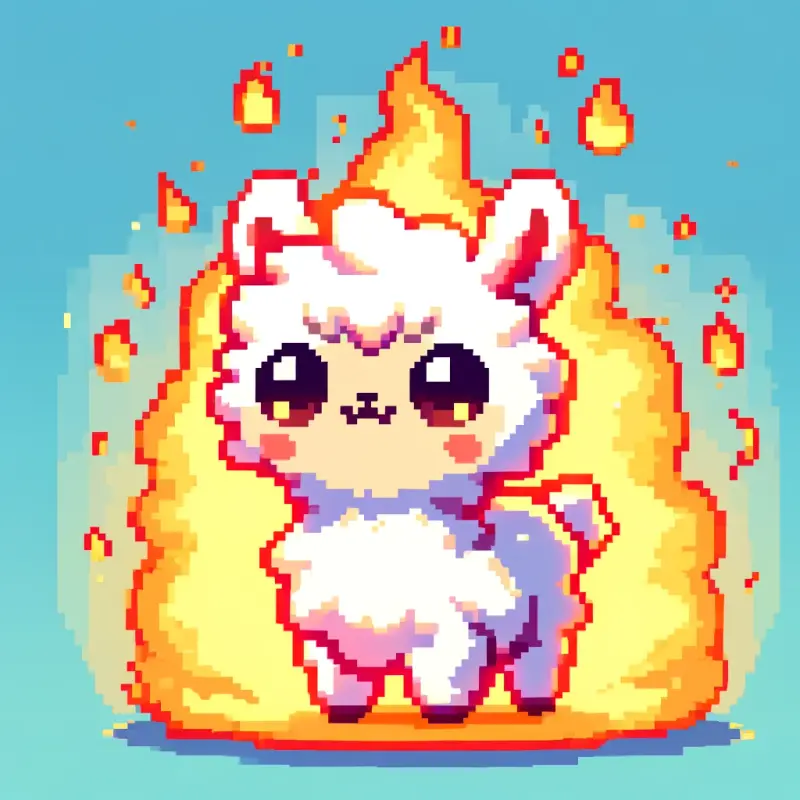

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Question:
Describe this image in detail
Answer:
The image showcases a playful scene with a white, fluffy llama as the main subject. The llama appears to be in the process of making a face, with its mouth open, revealing its pink tongue. The llama's face is characterized by a small nose and a pair of eyes that are quite expressive. It also has a distinct ear that stands out due to its pink color. The llama's fur is fluffy and white, and it has a small black nose.
The llama is depicted in a dynamic pose, with its hind leg visible. The leg appears to be positioned in a way that suggests the llama is in the middle of a movement.


In [13]:
from ov_nano_llava_helper import process_images, process_text_input
from PIL import Image

prompt = "Describe this image in detail"

messages = [{"role": "user", "content": f"<image>\n{prompt}"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/8bf7d9f2-018a-4498-bec4-55f17c273ecc"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images(image, None, processor)
input_ids, attention_mask = process_text_input(text, tokenizer)

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

display(image)
print(f"Question:\n{prompt}")
print("Answer:")

output_ids = ov_model.generate(input_ids, attention_mask=attention_mask, images=image_tensor, max_new_tokens=128, use_cache=True, streamer=streamer)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [14]:
from transformers import TextIteratorStreamer, StoppingCriteria
from threading import Thread
import torch


class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords, tokenizer, input_ids):
        self.keywords = keywords
        self.keyword_ids = []
        self.max_keyword_len = 0
        for keyword in keywords:
            cur_keyword_ids = tokenizer(keyword).input_ids
            if len(cur_keyword_ids) > 1 and cur_keyword_ids[0] == tokenizer.bos_token_id:
                cur_keyword_ids = cur_keyword_ids[1:]
            if len(cur_keyword_ids) > self.max_keyword_len:
                self.max_keyword_len = len(cur_keyword_ids)
            self.keyword_ids.append(torch.tensor(cur_keyword_ids))
        self.tokenizer = tokenizer
        self.start_len = input_ids.shape[1]

    def call_for_batch(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        offset = min(output_ids.shape[1] - self.start_len, self.max_keyword_len)
        self.keyword_ids = [keyword_id.to(output_ids.device) for keyword_id in self.keyword_ids]
        for keyword_id in self.keyword_ids:
            truncated_output_ids = output_ids[0, -keyword_id.shape[0] :]
            if torch.equal(truncated_output_ids, keyword_id):
                return True
        outputs = self.tokenizer.batch_decode(output_ids[:, -offset:], skip_special_tokens=True)[0]
        for keyword in self.keywords:
            if keyword in outputs:
                return True
        return False

    def __call__(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        outputs = []
        for i in range(output_ids.shape[0]):
            outputs.append(self.call_for_batch(output_ids[i].unsqueeze(0), scores))
        return all(outputs)


def bot_streaming(message, history):
    messages = []
    if message["files"]:
        image = message["files"][-1]["path"] if isinstance(message["files"][-1], dict) else message["files"][-1]
    else:
        for _, hist in enumerate(history):
            if isinstance(hist[0], tuple):
                image = hist[0][0]

    if len(history) > 0 and image is not None:
        messages.append({"role": "user", "content": f"<image>\n{history[1][0]}"})
        messages.append({"role": "assistant", "content": history[1][1]})
        for human, assistant in history[2:]:
            if assistant is None:
                continue
            messages.append({"role": "user", "content": human})
            messages.append({"role": "assistant", "content": assistant})
        messages.append({"role": "user", "content": message["text"]})
    elif len(history) > 0 and image is None:
        for human, assistant in history:
            if assistant is None:
                continue
            messages.append({"role": "user", "content": human})
            messages.append({"role": "assistant", "content": assistant})
        messages.append({"role": "user", "content": message["text"]})
    elif len(history) == 0 and image is not None:
        messages.append({"role": "user", "content": f"<image>\n{message['text']}"})
    elif len(history) == 0 and image is None:
        messages.append({"role": "user", "content": message["text"]})

    print(messages)
    image = Image.open(image).convert("RGB")
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_tensor = process_images(image, None, processor)
    input_ids, attention_mask = process_text_input(text, tokenizer)
    stop_str = "<|im_end|>"
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
    generation_kwargs = dict(
        input_ids=input_ids,
        attention_mask=attention_mask,
        images=image_tensor,
        streamer=streamer,
        max_new_tokens=128,
        stopping_criteria=[stopping_criteria],
        temperature=0.01,
    )
    thread = Thread(target=ov_model.generate, kwargs=generation_kwargs)
    thread.start()

    buffer = ""
    for new_text in streamer:
        buffer += new_text
        generated_text_without_prompt = buffer[:]
        yield generated_text_without_prompt

In [15]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/nano-llava-multimodal-chatbot/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=bot_streaming)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/